In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
!pip install lightning
!pip install pytorch-forecasting --extra-index-url https://download.pytorch.org/whl/cpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 846.0/846.0 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.5/849.5 kB 18.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cpu
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.8/399.8 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.8/159.8 kB 10.8 MB/s eta 0:00:00


In [35]:
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import pandas as pd
import torch

from pytorch_forecasting import Baseline, DeepAR, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import MAE, SMAPE, MultivariateNormalDistributionLoss
import yfinance as yf
import pandas as pd

In [4]:
  data = generate_ar_data(seasonality=10.0, timesteps=400, n_series=100, seed=42)

In [5]:
data

,series,time_idx,value
0,0,0,-0.000000
1,0,1,-0.046501
2,0,2,-0.097796
3,0,3,-0.144397
4,0,4,-0.177954
...,...,...,...
39995,99,395,-5.587069
39996,99,396,-4.986342
39997,99,397,-5.630228
39998,99,398,-5.745145


In [6]:
data["static"] = 2

In [7]:
data

,series,time_idx,value,static
0,0,0,-0.000000,2
1,0,1,-0.046501,2
2,0,2,-0.097796,2
3,0,3,-0.144397,2
4,0,4,-0.177954,2
...,...,...,...,...
39995,99,395,-5.587069,2
39996,99,396,-4.986342,2
39997,99,397,-5.630228,2
39998,99,398,-5.745145,2


In [8]:
data["date"] = pd.Timestamp("2020-01-01")

In [9]:
data.head()

,series,time_idx,value,static,date
0,0,0,-0.000000,2,2020-01-01
1,0,1,-0.046501,2,2020-01-01
2,0,2,-0.097796,2,2020-01-01
3,0,3,-0.144397,2,2020-01-01
4,0,4,-0.177954,2,2020-01-01


In [10]:
data["date"]+= pd.to_timedelta(data.time_idx, "D")

In [11]:
data

,series,time_idx,value,static,date
0,0,0,-0.000000,2,2020-01-01
1,0,1,-0.046501,2,2020-01-02
2,0,2,-0.097796,2,2020-01-03
3,0,3,-0.144397,2,2020-01-04
4,0,4,-0.177954,2,2020-01-05
...,...,...,...,...,...
39995,99,395,-5.587069,2,2021-01-30
39996,99,396,-4.986342,2,2021-01-31
39997,99,397,-5.630228,2,2021-02-01
39998,99,398,-5.745145,2,2021-02-02


In [12]:
max_encoder_length = 70
max_prediction_length = 20

In [13]:
training_cutoff = data["time_idx"].max() - max_prediction_length

In [14]:
context_length = max_encoder_length
prediction_length = max_prediction_length

In [15]:
data = data.astype(dict(series=str))


In [16]:
training = TimeSeriesDataSet(data[lambda x: x.time_idx <= training_cutoff],
                             time_idx = "time_idx",
                             target = "value",
                              categorical_encoders={"series": NaNLabelEncoder().fit(data.series)},
                             group_ids=["series"],
                             static_categoricals=[
        "series"
    ],
                             time_varying_unknown_reals=["value"],
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
)

In [17]:
validation = TimeSeriesDataSet.from_dataset(
    training, data, min_prediction_idx=training_cutoff + 1
)

In [18]:
batch_size = 128

In [19]:
train_dataloader = training.to_dataloader(
    train=True, batch_size=batch_size, num_workers=0, batch_sampler="synchronized"
)

In [20]:
val_dataloader = validation.to_dataloader(
    train=False, batch_size=batch_size, num_workers=0, batch_sampler="synchronized"
)

In [37]:
baseline_predictions = Baseline().predict(
    val_dataloader, trainer_kwargs=dict(accelerator="cpu"), return_y=True)
SMAPE()(baseline_predictions.output, baseline_predictions.y)

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores


tensor(0.5462)

In [38]:
baseline_predictions.output

tensor([[ 2.0639,  2.0639,  2.0639,  ...,  2.0639,  2.0639,  2.0639],
        [ 0.7167,  0.7167,  0.7167,  ...,  0.7167,  0.7167,  0.7167],
        [ 0.9500,  0.9500,  0.9500,  ...,  0.9500,  0.9500,  0.9500],
        ...,
        [ 1.6347,  1.6347,  1.6347,  ...,  1.6347,  1.6347,  1.6347],
        [-0.0318, -0.0318, -0.0318,  ..., -0.0318, -0.0318, -0.0318],
        [-4.7636, -4.7636, -4.7636,  ..., -4.7636, -4.7636, -4.7636]])

In [39]:
baseline_predictions.y

(tensor([[ 2.0388e+00,  1.7878e+00,  2.2029e+00,  ...,  2.5379e+00,
           2.3541e+00,  2.3235e+00],
         [ 8.7418e-01,  1.0387e+00,  1.0522e+00,  ...,  1.1287e+00,
           1.0512e+00,  1.1186e+00],
         [ 1.4580e+00,  1.4866e+00,  1.2217e+00,  ...,  1.2809e+00,
           1.2561e+00,  1.6840e+00],
         ...,
         [ 1.6189e+00,  1.4709e+00,  1.4108e+00,  ...,  1.5797e+00,
           1.5581e+00,  1.5454e+00],
         [-1.8162e-02, -5.5143e-03,  8.7946e-03,  ...,  2.2106e-02,
           7.8088e-03, -7.3420e-03],
         [-4.5210e+00, -4.4483e+00, -3.9518e+00,  ..., -5.6302e+00,
          -5.7451e+00, -4.6900e+00]]),
 None)

In [22]:
trainer = pl.Trainer(accelerator="cpu", gradient_clip_val=0.1)

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores


In [23]:
net = DeepAR.from_dataset(
    training,
    learning_rate=3e-2,
    hidden_size=30,
    rnn_layers=2,
    loss=MultivariateNormalDistributionLoss(rank=30),
    optimizer="Adam",
)

In [24]:
from pytorch_forecasting.tuning import Tuner

res = Tuner(trainer).lr_find(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    min_lr=1e-5,
    max_lr=1e0,
    early_stop_threshold=100,
)

INFO: `weights_only` was not set, defaulting to `False`.
INFO:lightning.pytorch.trainer.connectors.checkpoint_connector:`weights_only` was not set, defaulting to `False`.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: LR finder stopped early after 78 steps due to diverging loss.
INFO:lightning.pytorch.tuner.lr_finder:LR finder stopped early after 78 steps due to diverging loss.
INFO: Restoring states from the checkpoint path at /content/.lr_find_3d1a83fa-d4c5-4884-ae5c-63aea33c767c.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_3d1a83fa-d4c5-4884-ae5c-63aea33c767c.ckpt
INFO: Restored all states from the checkpoint at /content/.lr_find_3d1a83fa-d4c5-4884-ae5c-63aea33c767c.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_3d1a83fa-d4c5-4884-ae5c-63aea33c767c.ckpt
INFO: Learning rate set to 3.548133892335755e-05
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 3.548133892335755e-05


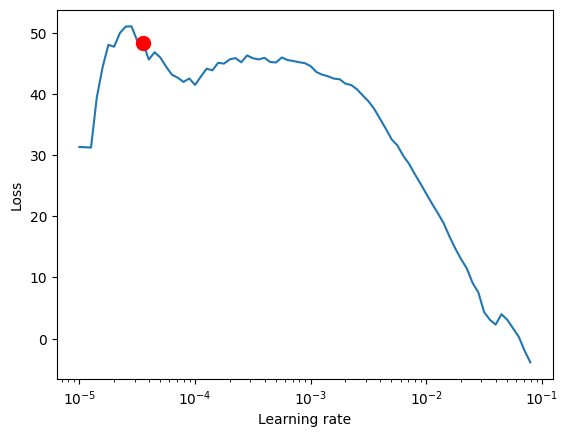

In [25]:
fig = res.plot(show=True, suggest=True)
fig.show()
net.hparams.learning_rate = res.suggestion()

In [26]:
early_stop_callback = EarlyStopping(
    monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min"
)
#Prevents overfitting

In [27]:
trainer = pl.Trainer(
    max_epochs=30,
    accelerator="cpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    callbacks=[early_stop_callback],
    limit_train_batches=50,
    enable_checkpointing=True,
)


net = DeepAR.from_dataset(
    training,
    learning_rate=1e-2,
    log_interval=10,
    log_val_interval=1,
    hidden_size=30,
    rnn_layers=2,
    optimizer="Adam",
    loss=MultivariateNormalDistributionLoss(rank=30),
)

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores


In [28]:
trainer.fit(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

┏━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name                   ┃ Type                               ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss                   │ MultivariateNormalDistributionLoss │      0 │ train │     0 │
│ 1 │ logging_metrics        │ ModuleList                         │      0 │ train │     0 │
│ 2 │ embeddings             │ MultiEmbedding                     │  2.1 K │ train │     0 │
│ 3 │ rnn                    │ LSTM                               │ 13.9 K │ train │     0 │
│ 4 │ distribution_projector │ Linear                             │    992 │ train │     0 │
└───┴────────────────────────┴────────────────────────────────────┴────────┴───────┴───────┘

Trainable params: 17.0 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 17.0 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 12                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO: `Trainer.fit` stopped: `max_epochs=30` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


In [29]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = DeepAR.load_from_checkpoint(best_model_path)

In [30]:
# best_model = net
predictions = best_model.predict(
    val_dataloader, trainer_kwargs=dict(accelerator="cpu"), return_y=True
)

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores


In [31]:
print(MAE()(predictions.output, predictions.y))
print(SMAPE()(predictions.output, predictions.y))

tensor(0.2566)
tensor(0.2636)


In [32]:
raw_predictions = net.predict(
    val_dataloader,
    mode="raw",
    return_x=True,
    n_samples=100,
    trainer_kwargs=dict(accelerator="cpu"),
)

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores


In [33]:
raw_predictions = best_model.predict(
    val_dataloader,
    mode="raw",
    return_x=True,
    n_samples=100,
    trainer_kwargs=dict(accelerator="cpu"),
)

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores


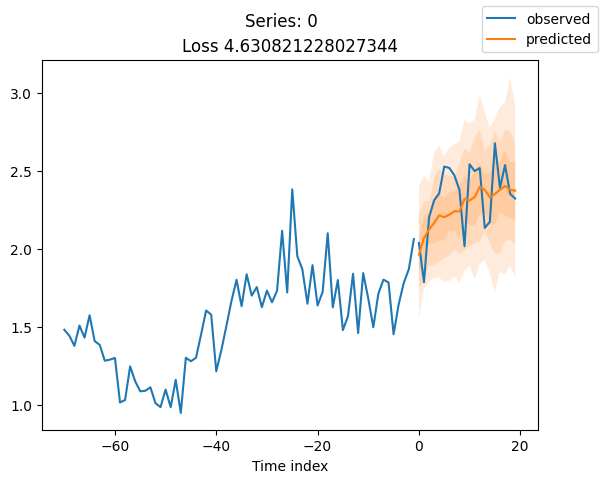

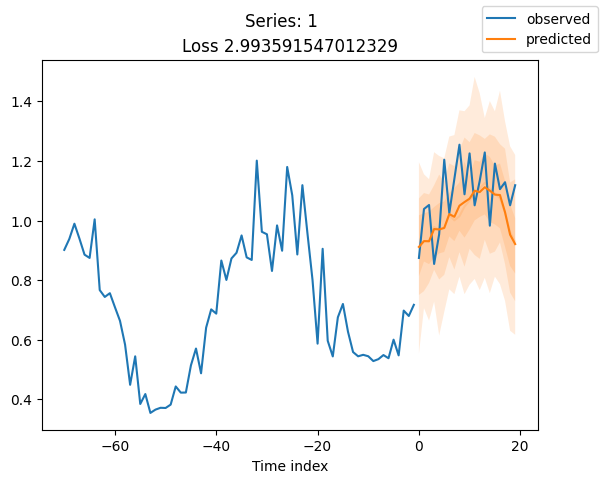

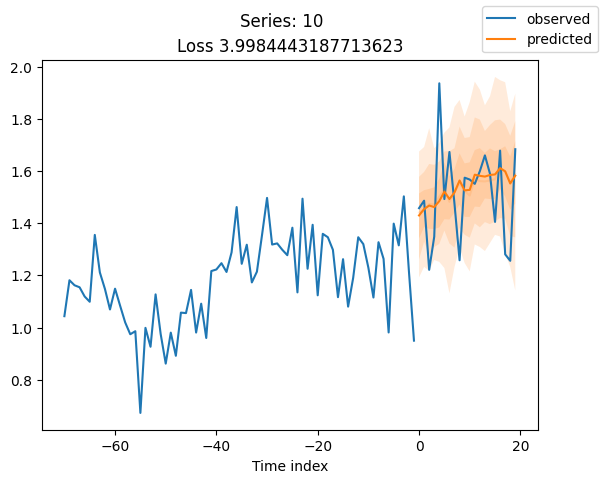

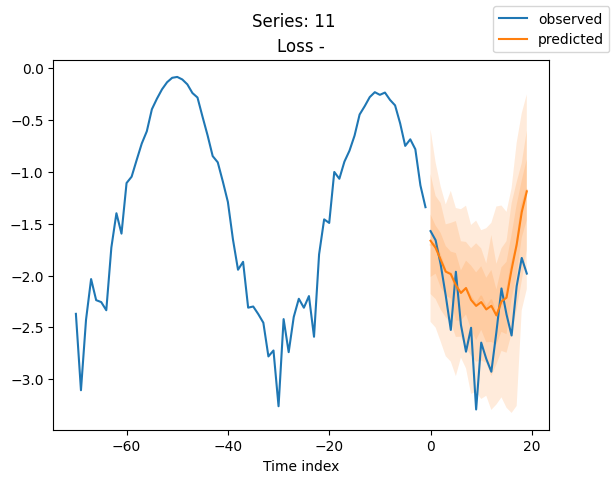

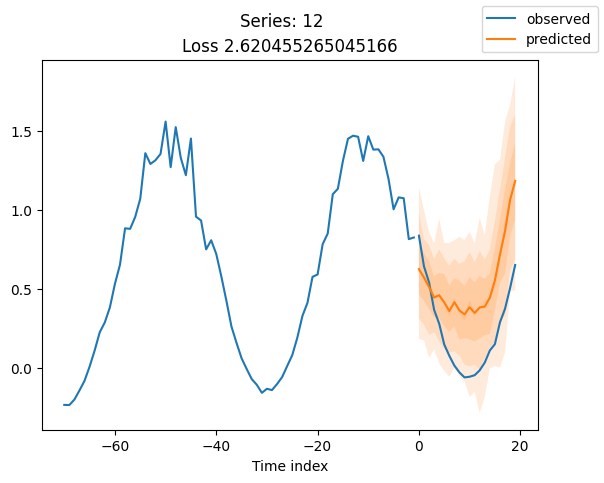

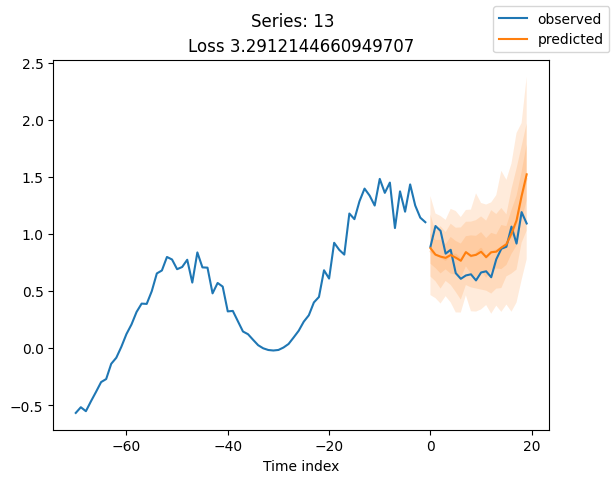

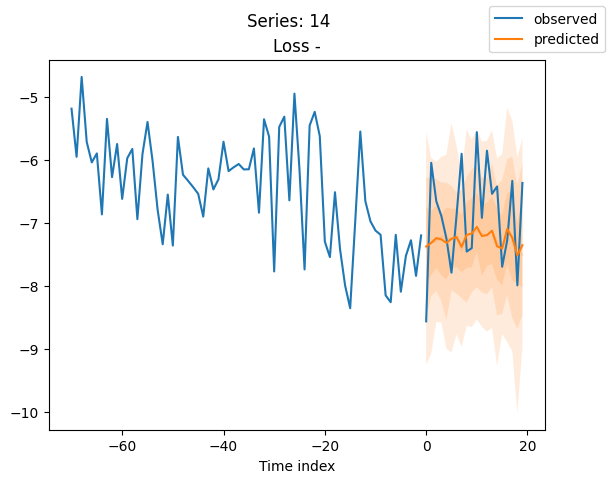

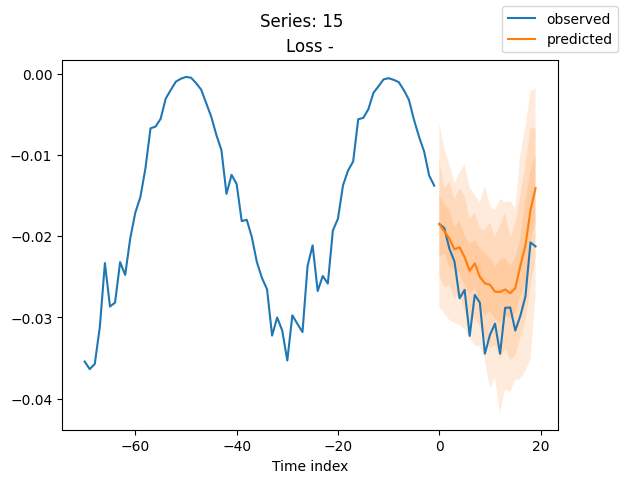

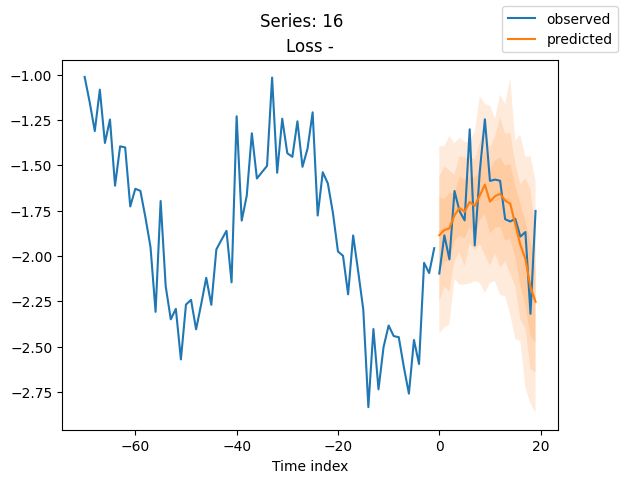

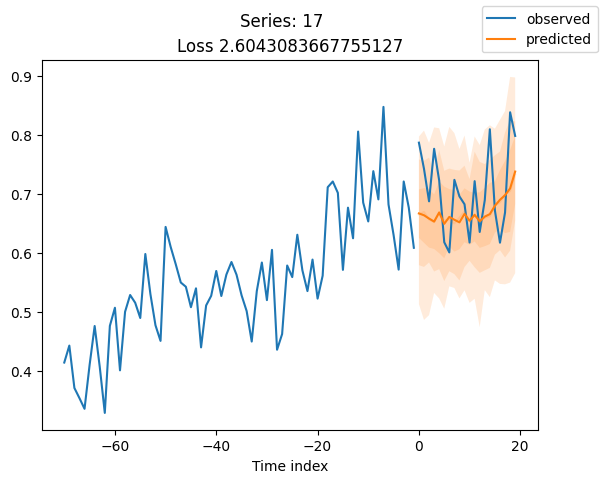

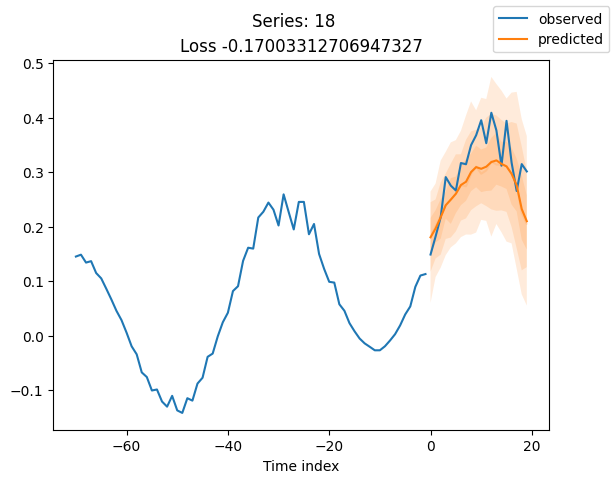

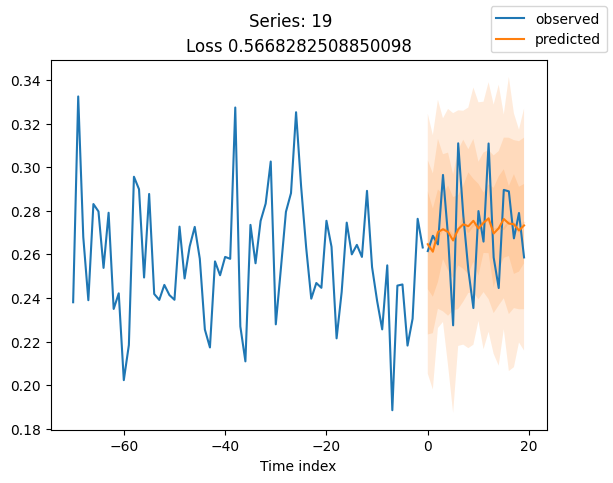

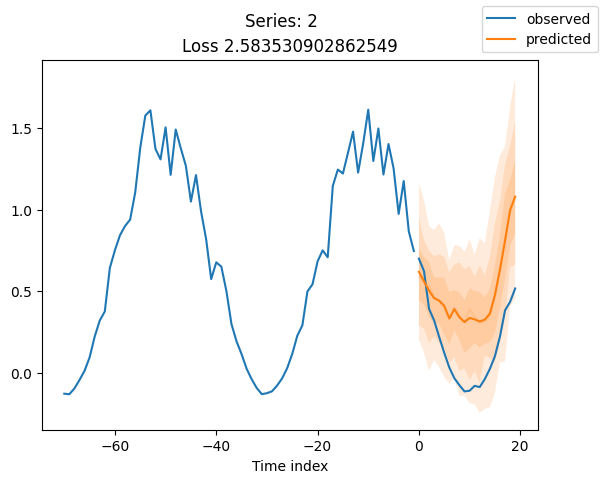

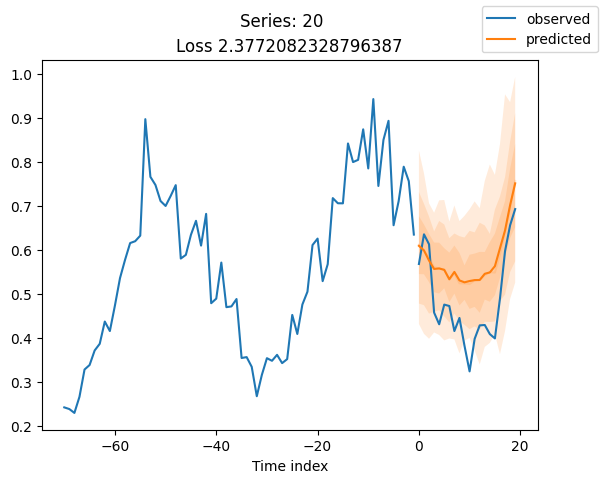

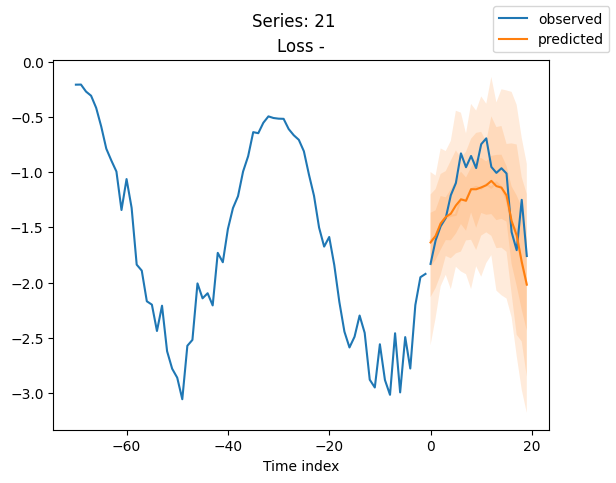

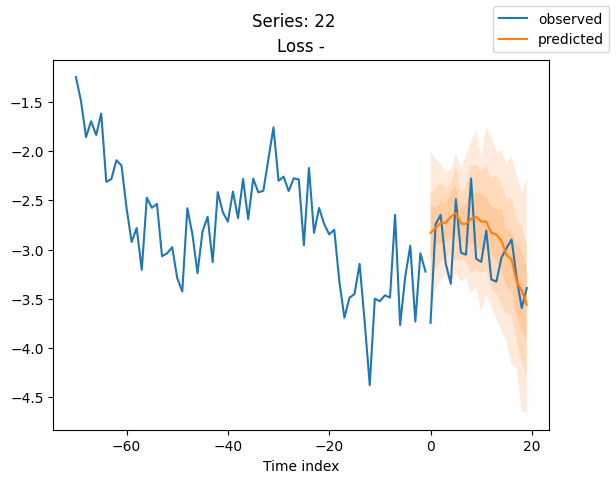

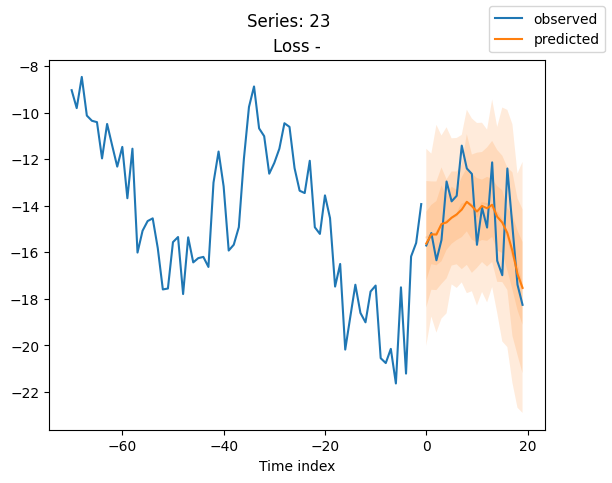

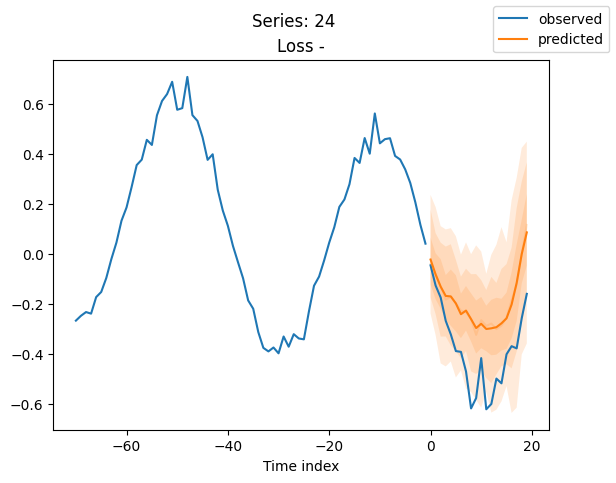

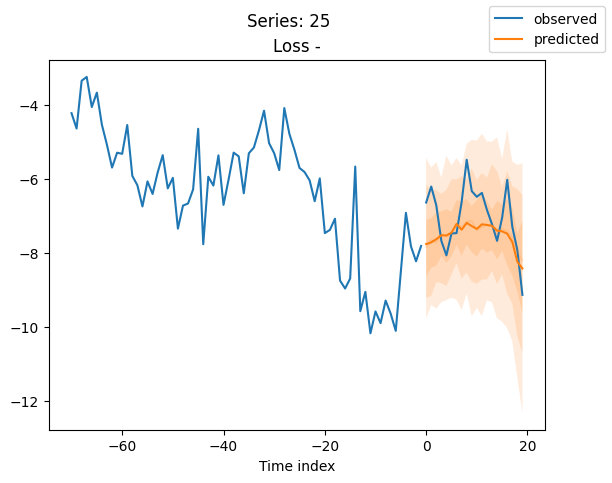

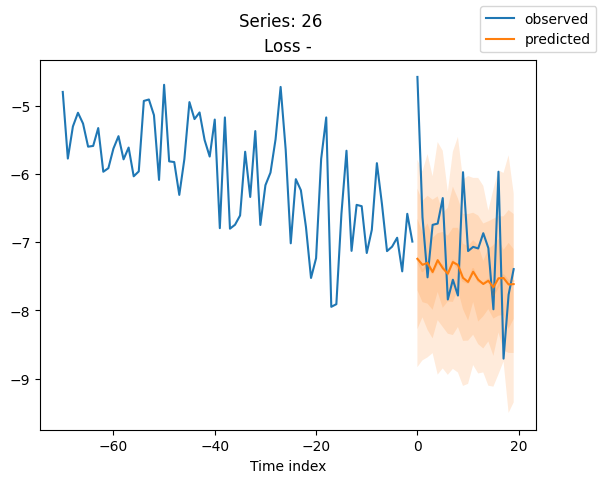

In [34]:
series = validation.x_to_index(raw_predictions.x)["series"]
for idx in range(20):  # plot 10 examples
    best_model.plot_prediction(
        raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True
    )
    plt.suptitle(f"Series: {series.iloc[idx]}")